# The plan

See: https://www.nature.com/articles/s41467-022-29804-5/figures/4

![The plan](plan.png "The plan")

In [1]:
import stk
import stko
import math
import py3Dmol
from itertools import product
from rdkit.Chem import AllChem as rdkit

In [2]:
def show_stk_mol(stk_mol):
    
    try:
        print(
            f'BB has {stk_mol.get_num_functional_groups()} '
            f'FGs and {stk_mol.get_num_placers()} placers'
        )
    except:
        pass
    
    data = rdkit.MolToMolBlock(stk_mol.to_rdkit_mol())
    p = py3Dmol.view(
        data=data,
        style={'stick':{'colorscheme':'cyanCarbon'}}, 
        width=400,
        height=400,
    )
    p.setBackgroundColor('#000000')
    p.zoomTo()
    p.show()

# Working:

Useful things:
* https://molview.org/

## Tritopics

In [3]:
tritopics = [
    stk.BuildingBlock(
        smiles='C1=C(C=C(C=C1Br)Br)Br',
        functional_groups=(stk.BromoFactory(), ),
    ),
    stk.BuildingBlock(
        smiles='C1(=NC(=NC(=N1)Br)Br)Br',
        functional_groups=(stk.BromoFactory(), ),
    ),
    stk.BuildingBlock(
        smiles='[C+](Br)(Br)Br',
        functional_groups=(stk.BromoFactory(), ),
    ),
    stk.BuildingBlock(
        smiles='[N+](Br)(Br)Br',
        functional_groups=(stk.BromoFactory(), ),
    ),
    stk.BuildingBlock(
        smiles='[C+]1([C+]([C+]1Br)Br)Br',
        functional_groups=(stk.BromoFactory(), ),
    ),
    stk.BuildingBlock(
        smiles='[C+]1[C+]([C+]([C+]1Br)Br)Br',
        functional_groups=(stk.BromoFactory(), ),
    ),
]

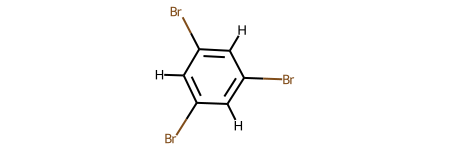

In [5]:
tritopics[0].to_rdkit_mol()

In [4]:
show_stk_mol(tritopics[0])

BB has 3 FGs and 3 placers


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Monotopics (r-groups)

### Mention placers!

In [6]:
monotopics = [
    stk.BuildingBlock(
        smiles='CCCBr',
        functional_groups=(stk.BromoFactory(placers=(0, 1)), ),
    ),
    stk.BuildingBlock.init_from_molecule(
        molecule=(stk.ConstructedMolecule(
            topology_graph=stk.polymer.Linear(
                building_blocks=(
                    stk.BuildingBlock(
                        smiles='CN',
                        functional_groups=(stk.PrimaryAminoFactory(), ),
                    ), 
                    stk.BuildingBlock(
                        smiles='NCCBr',
                        functional_groups=(
                            stk.BromoFactory(), 
                            stk.PrimaryAminoFactory(),
                        ),
                    ),
                ),
                repeating_unit='ABB',
                num_repeating_units=1,
            ),
        )),
        functional_groups=(stk.PrimaryAminoFactory(placers=(0, 1, 2, 3)), ),
    ),
    stk.BuildingBlock(
        smiles='COCOCC(=O)',
        functional_groups=(stk.AldehydeFactory(placers=(0, 1, 2)), ),
    ),
    stk.BuildingBlock(
        smiles='[Fe+][C+][N+][C+]Br',
        functional_groups=(stk.BromoFactory(placers=(0, 1)), ),
    ),
    stk.BuildingBlock(
        smiles='[Fe+][N+][C+]Br',
        functional_groups=(stk.BromoFactory(placers=(0, 1)), ),
    ),
    stk.BuildingBlock(
        smiles='[Fe+][C+][C+][C+]Br',
        functional_groups=(stk.BromoFactory(placers=(0, 1)), ),
    ),
    stk.BuildingBlock(
        smiles='[Pd+][C+][N+][C+]Br',
        functional_groups=(stk.BromoFactory(placers=(0, 1)), ),
    ),
]

[18:11:50] UFFTYPER: Unrecognized atom type: Fe3 (0)
[18:11:50] UFFTYPER: Unrecognized atom type: Fe3 (0)
[18:11:50] UFFTYPER: Unrecognized atom type: Fe3 (0)
[18:11:50] UFFTYPER: Unrecognized atom type: Pd5 (0)


### Note: Conformers are consistent with set Seed.

Therefore, you may want to have a check here that you build a reasonable conformer.

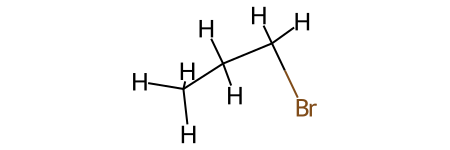

In [7]:
monotopics[0].to_rdkit_mol()

In [ ]:
show_stk_mol(monotopics[1])

## Building the components

### We need a new topology - how hard should that be?

* A lot of merging other functions.

### We do I use a Cage base class here??

* Vertices: Handling Monodentate is the same
* But edge assignment and organic nature fits cages better

In [8]:
from stk.molecular.topology_graphs.cage.vertices import _CageVertex

In [9]:
class TerminalVertex(_CageVertex):
    
    def place_building_block(self, building_block, edges):
        building_block = building_block.with_centroid(
            position=self._position,
            atom_ids=building_block.get_core_atom_ids(),
        )
        # return building_block.get_position_matrix()
        fg, = building_block.get_functional_groups()
        fg_centroid = building_block.get_centroid(
            atom_ids=fg.get_placer_ids(),
        )
        core_centroid = building_block.get_centroid(
            atom_ids=building_block.get_core_atom_ids(),
        )
        edge_centroid = (
            sum(edge.get_position() for edge in edges) / len(edges)
        )
        return building_block.with_rotation_between_vectors(
            start=(fg_centroid - core_centroid),
            # _cap_direction is defined by a subclass.
            target=edge_centroid - self._position,
            origin=self._position,
        ).get_position_matrix()
    
    def map_functional_groups_to_edges(self, building_block, edges):

        return {
            fg_id: edge.get_id() for fg_id, edge in enumerate(edges)
        }

In [10]:
class Core(stk.cage.Cage):
    # Special vertex definitions to be maintained.    
    # Vertex ID, position.
    # Note the classes are Cage specific!
    _vertex_prototypes = (
        stk.cage.NonLinearVertex(0, (0, 0, 0)),
        TerminalVertex(
            id=1, 
            position=(2, 0, 0), 
            use_neighbor_placement=False,
        ),        
        TerminalVertex(
            id=2, 
            position=(-1.2, 1., 0), 
            use_neighbor_placement=False,
        ),
        TerminalVertex(
            id=3, 
            position=(-1.2, -1., 0), 
            use_neighbor_placement=False,
        ),
    )

    # But Edges are not!
    _edge_prototypes = (
        # Edge ID, connected vertices by ID above.
        stk.Edge(
            id=0,
            vertex1=_vertex_prototypes[0],
            vertex2=_vertex_prototypes[1],
        ),
        stk.Edge(
            id=1,
            vertex1=_vertex_prototypes[0],
            vertex2=_vertex_prototypes[2],
        ),
        stk.Edge(
            id=2,
            vertex1=_vertex_prototypes[0],
            vertex2=_vertex_prototypes[3],
        ),
    )

### I promise that I am telling the truth about how long this took.

Because of the placers and the `use_neighbour_placement`, it took far longer than it should have (30 mins still!)

In [12]:
cores = []
for i, (cent, mono) in enumerate(product(tritopics, monotopics)):
    core = stk.ConstructedMolecule(
        Core(
            building_blocks={
                cent: (0, ), 
                mono: (1, 2, 3),
            },
        )
    )
    cores.append(core)

In [13]:
show_stk_mol(cores[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
cores = []
for i, (cent, mono) in enumerate(product(tritopics, monotopics)):
    core = stk.ConstructedMolecule(
        Core(
            building_blocks={
                cent: (0, ), 
                mono: (1, 2, 3),
            },
            optimizer=stk.MCHammer(),
        )
    )
    # opt = stko.UFF()
    # core = opt.optimize(core)
    cores.append(core)

print(f'built {len(cores)} cores')

built 42 cores


In [15]:
show_stk_mol(cores[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

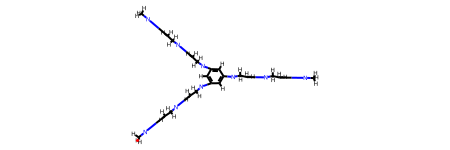

In [17]:
cores[1].to_rdkit_mol()

## Building the "polymers"

* Just use the host-guest code!

### Failure!

In [18]:
host = stk.BuildingBlock.init_from_molecule(cores[0])
guests = (
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[1]),
        displacement=(0, 0, 5),
        start_vector=stk.BuildingBlock.init_from_molecule(cores[1]).get_direction(),
        end_vector=(0, 0, 1),
    ),
)

polymer = stk.ConstructedMolecule(
    topology_graph=stk.host_guest.Complex(
        host=host,
        guests=guests,
    ),
)
show_stk_mol(polymer)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [19]:
host = stk.BuildingBlock.init_from_molecule(cores[0])

guests = (
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[1]),
        displacement=(0, 0, 5),
    ),
)

polymer = stk.ConstructedMolecule(
    topology_graph=stk.host_guest.Complex(
        host=host,
        guests=guests,
    ),
)
show_stk_mol(polymer)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
host = stk.BuildingBlock.init_from_molecule(cores[2])

guests = (
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[1]),
        displacement=(0, 0, 5),
    ),
)

polymer = stk.ConstructedMolecule(
    topology_graph=stk.host_guest.Complex(
        host=host,
        guests=guests,
    ),
)
show_stk_mol(polymer)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
host = stk.BuildingBlock.init_from_molecule(cores[2])

guests = (
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[3]),
        displacement=(0, 0, 5),
    ),
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[9]),
        displacement=(0, 0, 10),
    ),
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[5]),
        displacement=(0, 0, 15),
    ),
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[11]),
        displacement=(0, 0, 20),
    ),
)

polymer = stk.ConstructedMolecule(
    topology_graph=stk.host_guest.Complex(
        host=host,
        guests=guests,
    ),
)
show_stk_mol(polymer)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

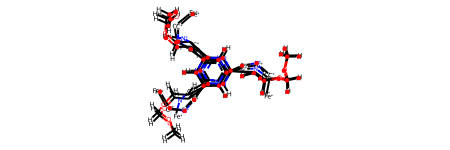

In [23]:
polymer.to_rdkit_mol()

In [ ]:
host = stk.BuildingBlock.init_from_molecule(cores[2])

guests = (
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[4]),
        displacement=(0, 0, 5),
    ),
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[2]),
        displacement=(0, 0, 10),
        start_vector=(0, 0, 1),
        end_vector=(0, 0, -1),
    ),
)

polymer = stk.ConstructedMolecule(
    topology_graph=stk.host_guest.Complex(
        host=host,
        guests=guests,
    ),
)
show_stk_mol(polymer)

## Optimising the polymers

###  a failure

In [ ]:
host = stk.BuildingBlock.init_from_molecule(cores[2])

guests = (
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[0]),
        displacement=(0, 0, 5),
    ),
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[0]),
        displacement=(0, 0, 10),
    ),
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[0]),
        displacement=(0, 0, 15),
    ),
)

polymer = stk.ConstructedMolecule(
    topology_graph=stk.host_guest.Complex(
        host=host,
        guests=guests,
        optimizer=stk.Spinner(
            rotation_step_size=0.0,
            step_size=1.5,
            num_conformers=100,
            nonbond_epsilon=1,
        ),
    ),
)

show_stk_mol(polymer)

In [ ]:
host = stk.BuildingBlock.init_from_molecule(cores[2])

guests = (
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[0]),
        displacement=(0, 0, 5),
    ),
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[0]),
        displacement=(0, 0, 10),
    ),
    stk.host_guest.Guest(
        building_block=stk.BuildingBlock.init_from_molecule(cores[0]),
        displacement=(0, 0, 15),
    ),
)

polymer = stk.ConstructedMolecule(
    topology_graph=stk.host_guest.Complex(
        host=host,
        guests=guests,
    ),
)
show_stk_mol(polymer)

In [ ]:
opt = stko.UFF(ignore_inter_interactions=False)
polymer = opt.optimize(polymer)
show_stk_mol(polymer)

# Running the Evolutionary Algorithm on the core

Given the list of tritopic and monotopic building blocks, can we find the most "rigid" one? - This is just a toy example.

In [ ]:
import rdkit.Chem.AllChem as rdkit
import itertools as it
import numpy as np

In [ ]:
def get_rigidity(molecule):
    num_rotatable_bonds = rdkit.CalcNumRotatableBonds(molecule)
    # Add 1 to the denominator to prevent division by 0.
    return 1 / (num_rotatable_bonds + 1)

def get_fitness_value(molecule):
    rdkit_molecule = molecule.to_rdkit_mol()
    rdkit.SanitizeMol(rdkit_molecule)
    # Multiply by 100 just to scale the values up a bit, which
    # makes for nicer plots later.
    return 100*get_rigidity(rdkit_molecule)


In [ ]:
len(tritopics), len(monotopics)

In [ ]:
def get_initial_population(tritopics, monotopics):
    for tri, mono in it.product(tritopics[:3], monotopics[:3]):
        yield stk.MoleculeRecord(
            topology_graph=Core(
                building_blocks={
                    cent: (0, ), 
                    mono: (1, 2, 3),
                },
                optimizer=stk.MCHammer(),
            ),
        )

initial_population = tuple(
    get_initial_population(tritopics, monotopics)
)

In [ ]:
def get_num_functional_groups(building_block):
    return building_block.get_num_functional_groups()

def is_mono(building_block):
    return get_num_functional_groups(building_block) == 1

def is_tri(building_block):
    return get_num_functional_groups(building_block) == 3

generator = np.random.RandomState(4)
mutator = stk.RandomMutator(
    mutators=(
        # Substitutes a monotopic building block with a 
        # random monotopic building block.
        stk.RandomBuildingBlock(
            building_blocks=monotopics,
            is_replaceable=is_mono,
            random_seed=generator.randint(0, 1000),
        ),
        # Substitutes a tritopic building block with a 
        # random tritopic building block.
        stk.RandomBuildingBlock(
            building_blocks=tritopics,
            is_replaceable=is_tri,
            random_seed=generator.randint(0, 1000),
        ),
    ),
    random_seed=generator.randint(0, 1000),
)

In [ ]:
ea = stk.EvolutionaryAlgorithm(
    initial_population=initial_population,
    fitness_calculator=stk.FitnessFunction(get_fitness_value),
    mutator=mutator,
    crosser=stk.GeneticRecombination(
        get_gene=get_num_functional_groups,
    ),
    generation_selector=stk.Best(
        num_batches=5,
        duplicate_molecules=False,
    ),
    mutation_selector=stk.Roulette(
        num_batches=5,
        random_seed=generator.randint(0, 1000),
    ),
    crossover_selector=stk.Roulette(
        num_batches=3,
        batch_size=2,
        random_seed=generator.randint(0, 1000),
    ),
)

writer = stk.MolWriter()
generations = []
for i, generation in enumerate(ea.get_generations(10)):
    generations.append(generation)
    
    for molecule_id, molecule_record in enumerate(
        generation.get_molecule_records()
    ):
        writer.write(
            molecule=molecule_record.get_molecule(),
            path=f'g_{i}_m_{molecule_id}.mol',
        )

In [ ]:
fitness_progress = stk.ProgressPlotter(
    generations=generations,
    get_property=lambda record: record.get_fitness_value(),
    y_label='Fitness Value',
)
fitness_progress.write('fitness_progress.png')